In [1]:
# Standard Packages
from torch.utils.data import random_split, DataLoader
import torch
import wandb
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
# Custom Packages
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
import ssapp.data.AntennaDatasetLoaders as AntennaDatasets
from ssapp.Utils import train_test_data_split, FigureSaver
from ssapp.data.Metrics import relRMSE, relRMSE_pytorch
from ssapp.models.HelperFunctions import loadModel
from ssapp.models.NeuralNetworkModels.variational_autoencoder import VAE
from ssapp.models.NeuralNetworkModels.Autoencoders import AutoencoderFullyConnected, AutoencoderFCResNet
##Settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2



#model = loadModel(VAE(),'VAE_test.pt')
model=loadModel(AutoencoderFullyConnected(latent_size = 2),'deft-plasma-3best_val.pt',subfolder='FarFieldAutoEncoder')

model.double()


figSaver = FigureSaver(subfolder = 'Autoencoder Plots')

/zhome/5b/b/127277/Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction/models/FarFieldAutoEncoder/deft-plasma-3best_val.pt


tensor([[0.4327, 0.1291]])


<Figure size 432x288 with 0 Axes>

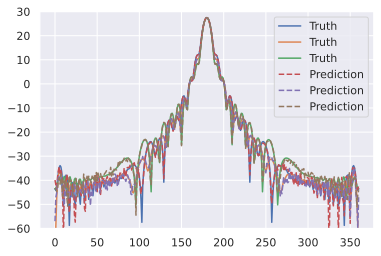

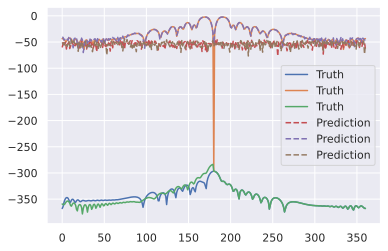

<Figure size 432x288 with 0 Axes>

In [23]:
import plotly.express as px
import plotly.graph_objects as go
AntennaDatasets.set_global_random_seed(42)
dataset = load_serialized_dataset('CircularHornDataset1_Val')
#dataset = load_serialized_dataset('PatchAntennaDataset2')

from ssapp.data.AntennaDatasetLoaders import get_single_dataset_example

mag = lambda a,b: 20*np.log10(np.sqrt(a**2+b**2))
#mag = lambda a,b: (np.sqrt(a**2+b**2))
params, fields = get_single_dataset_example(dataset)
print(params)

pred = model(fields).detach()

plt.plot(mag(fields[0,:,:,0],fields[0,:,:,1]),label = 'Truth')
plt.plot(mag(pred[0,:,:,0],pred[0,:,:,1]),label = 'Prediction',linestyle = '--')
plt.ylim([-60,30])
plt.legend()
plt.figure()
plt.plot(mag(fields[0,:,:,2],fields[0,:,:,3]),label = 'Truth')
plt.plot(mag(pred[0,:,:,2],pred[0,:,:,3]),label = 'Prediction',linestyle = '--')
plt.legend()
plt.figure()



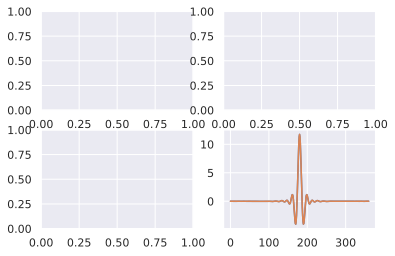

In [25]:
plt.subplots(nrows=2,ncols=2)



plt.plot(fields[0,:,0,0],label = 'Truth')
plt.plot(pred[0,:,0,0],label = 'Prediction')

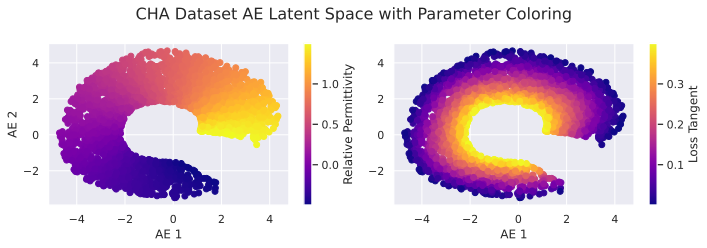

In [29]:
from torch.utils.data.dataloader import DataLoader
from ssapp.visualization.PCA_Visualisation import plotParameterColoredLatentSpaceFromAutoencoder

train_dataset = load_serialized_dataset('CircularHornDataset1_Train')
val_dataset =load_serialized_dataset('CircularHornDataset1_Val')

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))




def plotVAELantet(param = 0):
    plt.figure()
    plt.title('Latent Space Samples')
    params, fields = next(iter(train_loader))
    p = model.encode(fields)
    print(p.shape)
    p = p.detach()
    plt.scatter(p[:,0],p[:,1],c=params[:,param],cmap = 'plasma')


plotParameterColoredLatentSpaceFromAutoencoder(train_dataset,
                                                model=model,
                                                param_names=['Relative Permittivity','Loss Tangent'],
                                                figsize=(10,3.5),
                                                title = 'CHA Dataset AE Latent Space with Parameter Coloring')
figSaver('CHA_autoencoder_parameter_colouring')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


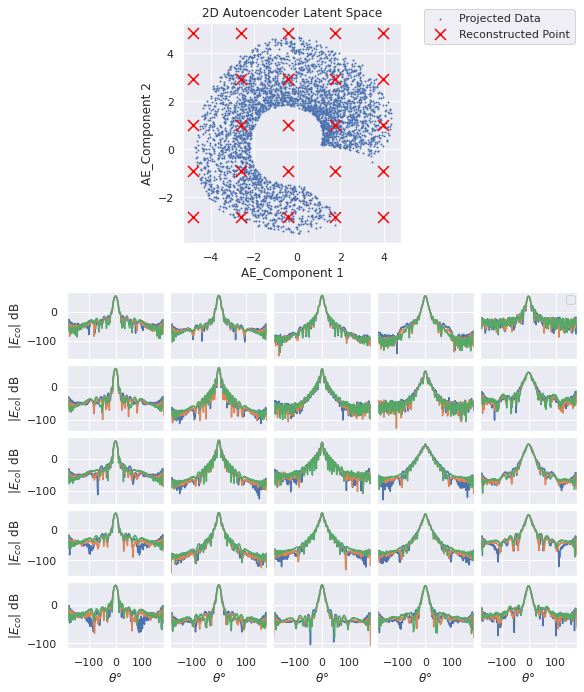

In [ ]:
from ssapp.visualization.PCA_Visualisation import plotInverseTransformFromAutoencoder

dataset = load_serialized_dataset('CircularHornDataset1')
plotInverseTransformFromAutoencoder(dataset,model,num_std_dev = 2,plot_scaling =False)
figSaver('CHA_autoencoder_latent_space_reconstruction')

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

train_params, train_fields = next(iter(train_loader))
val_params, val_field = next(iter(val_loader))

Z = model.encode(train_fields)
print(Z.shape)
P = GaussianProcessRegressor().fit(train_params.detach(),Z.detach())


torch.Size([2800, 2])


tensor(0.0099, dtype=torch.float64, grad_fn=<SqrtBackward0>)
0.0011327837870361945


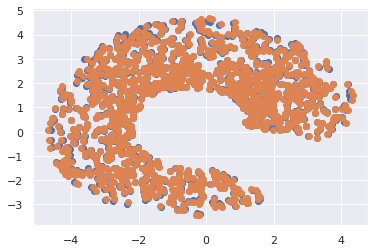

In [ ]:
pred = P.predict(val_params.detach())

latent_space = model.encode(val_field)

plt.figure()
plt.scatter(pred[:,0],pred[:,1])
plt.scatter(latent_space[:,0].detach(),latent_space[:,1].detach())


pred_fields = model.decode(torch.tensor(pred))
from ssapp.data.Metrics import relRMSE_pytorch, relRMSE

print(relRMSE_pytorch(val_field,pred_fields))


from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
kernel = ConstantKernel(1, constant_value_bounds="fixed") * Matern(length_scale=0.801173528334133,length_scale_bounds='fixed',nu=6.547059566968904)



##

pure_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

pure_gp.fit(train_params.detach(),train_fields.detach().reshape(len(train_fields),-1))

pure_pred_fields = pure_gp.predict(val_params).reshape(-1,361,3,4)

print(relRMSE(val_field.detach(),pure_pred_fields))

torch.Size([1200, 2])


IndexError: index 2 is out of bounds for dimension 1 with size 2

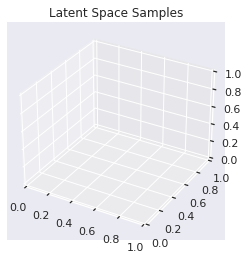

In [ ]:
from torch.utils.data.dataloader import DataLoader

train_dataset = load_serialized_dataset('CircularHornDataset1_Train')
val_dataset =load_serialized_dataset('CircularHornDataset1_Val')

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))




def plotVAELantet3d(param = 0):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    plt.title('Latent Space Samples')
    params, fields = next(iter(val_loader))
    p = model.encode(fields)
    print(p.shape)
    p = p.detach()
    ax.scatter(p[:,0],p[:,1], p[:,2], c=params[:,param],cmap = 'plasma')


plotVAELantet3d(0)
plotVAELantet3d(1)

In [ ]:


train_params, train_fields = next(iter(train_loader))
test_params, test_fields = next(iter(val_loader))
print(train_params.shape)
train_pred = model(train_fields)
test_pred = model(test_fields)

print('Relative RMSE Train',relRMSE_pytorch(train_pred, train_fields).item())
print('Relative RMSE Test',relRMSE_pytorch(test_pred, test_fields).item())